In [1]:
%matplotlib inline
import os 
import sys
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
import math 
from outliers import smirnov_grubbs as grubbs

plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

datadir       = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM/Oct_20'
mrsdir        = '/Users/kanaan/SCR/Dataframes_20150820/REVISION_DF'
clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'
savefigdir    = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python'

measures = [#'Puta', 'Caud', 
            'STRx', #'Thal',
            'SN', 'STN', 'RN',  'DN', 'GPi' , 'GPe', 'Pall', 'GM','WM','CSF'  # 'Hipp', 'Accu', 'Amyg',
            #'STR_EXE','STR_LIM','STR_cMOT', 'STR_rMOT', 'STRx',#'AAN_PPN','AAN_VTA',
            # 'hippo_presubiculum',  'hippo_subiculum', 'ant_Insula','sup_Insula','inf_Insula',
           ]
bigmasks = ['BrainStem','BasalGanglia', 'ALL_NUCLEI' ]

#measures= ['R_' + i for i in measures]
#bigmasks= ['R_' + i for i in bigmasks]


drop_c = ['WSKT','SC1T','LL5T', 'GSAT'] 
# WSKT,SC1T,LL5T Young Females scanned extra for MRS review. 
# GSAT removed since HSPP female removed 
drop_p = ['AA8P', 'RA9P', 'STDP','NL2P','HSPP', 'DF2P'] 
# AA8P motion outliers via mehalonobis distance for Quality metrics 
# rest – mehalonobis distance for SN,STN,Puta

'''Mahalanobis distances: these measure the influence of a case by examining the distance of cases from the mean(s) 
of the predictor variable(s). One needs to look for the cases with the highest values. It is not easy to establish 
a cut-off point at which to worry, although Barnett and Lewis (1978) have produced a table of critical values dependent
on the number of predictors and the sample size. From their work it is clear that even with large samples (N = 500) 
and  five predictors, values above 25 are cause for concern. In smaller samples (N = 100) and with fewer predictors 
(namely, three) values greater than 15 are problematic, and in very small samples (N = 30) with only two predictors 
values greater than 11 should be examined. However, for more specic advice, refer to Barnett and Lewis’s (1978) table'''

'Mahalanobis distances: these measure the influence of a case by examining the distance of cases from the mean(s) \nof the predictor variable(s). One needs to look for the cases with the highest values. It is not easy to establish \na cut-off point at which to worry, although Barnett and Lewis (1978) have produced a table of critical values dependent\non the number of predictors and the sample size. From their work it is clear that even with large samples (N = 500) \nand  five predictors, values above 25 are cause for concern. In smaller samples (N = 100) and with fewer predictors \n(namely, three) values greater than 15 are problematic, and in very small samples (N = 30) with only two predictors \nvalues greater than 11 should be examined. However, for more specic advice, refer to Barnett and Lewis\xe2\x80\x99s (1978) table'

In [2]:
def get_all_dfs(img, population, study_id, trt=False):
    quant = 'median'
    QSM = pd.read_csv(os.path.join(datadir, '%s_%s_%s_%s.csv'%(img, quant, population, study_id)),index_col = 0)
    QSM['Gender']  = QSM['Gender'].map({' F': 1, ' M': 0})
    
    CLN = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_a.csv'%(population)), index_col=0)
    CLN.columns = ['CLN_' + str(col) for col in CLN.columns]    

    def get_mrs(vox):
        if trt == False:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%(vox, population, study_id)),index_col = 0)
        elif trt == True:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_trt_%s.csv'%(vox, population, study_id)),index_col = 0)
        df.columns = ['%s_'%vox + str(col) for col in df.columns]
        return df
    df = pd.concat([QSM, get_mrs('STR'), CLN], axis=1, join_axes=[QSM.index])
    df['L_STRx']    = (df['L_Puta'] + df['L_Caud']) / 2
    df['R_STRx']    = (df['R_Puta'] + df['R_Caud']) / 2
    df['STRx']     = (df['R_STRx'] + df['L_STRx']) / 2
    df['L_BrainStem']    = (df['L_STN'] + df['L_SN'] +  df['L_RN']) / 3
    df['R_BrainStem']    = (df['R_STN'] + df['R_SN'] +  df['R_RN']) / 3
    df['L_BasalGanglia'] = (df['L_Puta'] + df['L_Caud'] +  df['L_Pall'] ) / 3
    df['R_BasalGanglia'] = (df['R_Puta'] + df['R_Caud'] +  df['R_Pall'] ) / 3
    df['L_ALL_NUCLEI'] = (df['L_BrainStem'] + df['L_BasalGanglia'] + df['L_DN']) / 3
    df['R_ALL_NUCLEI'] = (df['R_BrainStem'] + df['R_BasalGanglia'] + df['R_DN']) / 3
    df['ALL_NUCLEI'] = (df['BrainStem'] + df['BasalGanglia']) /3
    return df

controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
#patients_b = get_all_dfs('QSM', 'patients', 'b', trt=True)#.drop(drop_p, axis = 0) 


# Run QSM Statistical modeling

In [3]:
# Compare the groups by modeling GROUP, AGE, GENDER, EFC and FD in a multiple linear regression model as in (Schmaal, Mol Psych, 2015)
# Need to ensure normality of data and  homogeneity of Variance
## Normality is assessed via the Kolmogrov-Smirnov Test for each sample independently.
    ## http://stats.stackexchange.com/questions/57885/how-to-interpret-p-value-of-kolmogorov-smirnov-test-python
## Homogeneity of Variance is assessed via Levenes Test
## Effect size is calculated with Cohen’s d-metric.

In [4]:
def cohen_d(df1,df2, metabolite):
    x = df1[metabolite].dropna(axis=0)
    y = df2[metabolite].dropna(axis=0)
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)

def grubbs_outliers(df, measure, alpha = 0.05):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 

def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def make_statistical_comparison(df_controls, df_patients, stat, measures = measures, grubbs = False, ESD = False):
    df_controls['Population'] = 0
    df_patients['Population'] = 1
    cols = ['N','Controls', 'Patients','Levene','KS', 'KS_C', 'KS_P','D', 'Statistic', 'p_val', 'p_fdr', 'sig']
    dfs = pd.DataFrame(index= cols, columns=measures)
    
    if grubbs:
        for measure in measures:
            grubbs_controls = grubbs_outliers(df_controls, measure)
            grubbs_patients = grubbs_outliers(df_patients, measure)
            print 'GRUBBS OUTLIERS=', measure, grubbs_controls, grubbs_patients
            for subject in grubbs_controls :
                df_controls.ix[subject,measure] = np.nan
            for subject in grubbs_patients :
                df_patients.ix[subject,measure] = np.nan
    elif ESD:
        for measure in measures:
            grubbs_controls = gESD_outliers(df_controls, measure)
            grubbs_patients = gESD_outliers(df_patients, measure)
            print 'gESD OUTLIERS=', measure, grubbs_controls, grubbs_patients
            for subject in grubbs_controls :
                df_controls.ix[subject,measure] = np.nan
            for subject in grubbs_patients :
                df_patients.ix[subject,measure] = np.nan
        
    df = pd.concat([df_controls, df_patients])
    for measure in measures:
        if stat == 'MR':
            formula = '%s ~ Population + Age + Gender'%measure
            model   = smf.ols(formula=formula, data = df)
            fit     = model.fit()
            p_val   = np.round(fit.pvalues[1],5)
            t_val   = np.round(fit.tvalues[1],3)
        
        elif stat == 'MW':
            
            t_val, p_val = mannwhitneyu(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        elif stat == 'TT':
            t_val, p_val = ttest_ind(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        xval = 1000
        npr  = 4
        dfs.ix['N'][measure] = len(df_controls[measure].dropna()), len(df_patients[measure].dropna())
        dfs.ix['Levene'][measure] = np.round(levene(df_controls[measure].dropna(), df_patients[measure].dropna())[1],2)
        dfs.ix['KS'][measure] = np.round(ks_2samp(preprocessing.scale(df_controls[measure].dropna()), 
                                                  preprocessing.scale(df_patients[measure].dropna()))[1], 2)
        dfs.ix['KS_C'][measure] = np.round(kstest(preprocessing.scale(df_controls[measure].dropna()), 'norm')[1],2)
        dfs.ix['KS_P'][measure] = np.round(kstest(preprocessing.scale(df_patients[measure].dropna()), 'norm')[1],2)
        dfs.ix['D'][measure]    = cohen_d(df_controls, df_patients,measure)
        dfs.ix['Controls'][measure] = '%s±%s'%(xval*np.round(np.mean(df_controls[measure]),npr), 
                                              xval*np.round(np.std(df_controls[measure]), npr))   
        dfs.ix['Patients'][measure] = '%s±%s'%(xval*np.round(np.mean(df_patients[measure]),npr), 
                                              xval*np.round(np.std(df_patients[measure]), npr))   
        dfs.ix['D'][measure]    = np.round(cohen_d(df_controls, df_patients,measure),2)
        dfs.ix['Statistic'][measure]= np.round(t_val,2)        
        dfs.ix['p_val'][measure]    = np.round(p_val,5)
        
        if p_val < 0.05:
            print measure, 'p =', np.round(p_val,3)
    
    dfs = dfs.T.sort_values('p_val')
    dfs['p_fdr'] = fdrcorrection0(dfs.p_val)[1]
    dfs['sig'] = fdrcorrection0(dfs.p_val)[0]
    return dfs, df 

In [174]:
controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
bgs, bg = make_statistical_comparison(controls_a, patients_a, 'MW', measures=bigmasks, ESD=0)
bgs

BrainStem p = 0.001
BasalGanglia p = 0.04
ALL_NUCLEI p = 0.001


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,Statistic,p_val,p_fdr,sig
ALL_NUCLEI,"(22, 22)",44.2±9.1,33.3±9.5,0.7,0.98,1,0.94,1.15,103,0.00058,0.0012,True
BrainStem,"(22, 22)",113.1±23.6,88.7±21.9,0.99,0.82,0.68,0.94,1.05,107,0.0008,0.0012,True
BasalGanglia,"(22, 22)",19.6±9.4,11.2±11.3,0.04,0.33,0.36,0.4,0.79,167,0.04017,0.04017,True


In [5]:
controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
X, XX = make_statistical_comparison(controls_a, patients_a, 'MW', ESD=1)
X

gESD OUTLIERS= STRx [] []
gESD OUTLIERS= SN [] []
gESD OUTLIERS= STN [] []
gESD OUTLIERS= RN [] []
gESD OUTLIERS= DN [] []
gESD OUTLIERS= GPi [] []
gESD OUTLIERS= GPe [] []
gESD OUTLIERS= Pall [] []
gESD OUTLIERS= GM [] []
gESD OUTLIERS= WM [] []
gESD OUTLIERS= CSF [] []
STRx p = 0.021
SN p = 0.04
STN p = 0.0
RN p = 0.033


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,Statistic,p_val,p_fdr,sig
STN,"(22, 22)",78.2±24.5,48.0±28.1,0.44,0.82,0.7,0.98,1.12,96,0.00032,0.00352,True
STRx,"(22, 22)",8.7±13.1,-0.3±10.4,0.66,0.82,0.45,0.96,0.75,155,0.02116,0.110467,False
RN,"(22, 22)",128.9±45.6,104.4±34.4,0.34,0.98,0.88,0.98,0.59,163,0.03269,0.110467,False
SN,"(22, 22)",127.2±22.0,111.9±28.2,0.37,0.82,0.43,0.79,0.59,167,0.04017,0.110467,False
DN,"(22, 22)",70.3±34.2,50.8±44.6,0.33,0.98,0.99,1,0.48,175,0.05927,0.130394,False
GPi,"(22, 22)",100.3±24.6,91.3±23.6,0.96,0.56,0.82,0.88,0.36,186,0.09633,0.168971,False
Pall,"(22, 22)",82.8±17.4,75.5±19.1,0.53,0.98,0.95,1,0.39,197,0.14812,0.168971,False
WM,"(22, 22)",-32.5±9.1,-36.0±12.2,0.21,0.82,0.8,1,0.32,197.5,0.15084,0.168971,False
GM,"(22, 22)",-26.4±7.8,-29.9±11.2,0.04,0.82,0.9,0.86,0.35,198,0.15361,0.168971,False
CSF,"(22, 22)",-26.4±7.8,-29.9±11.2,0.04,0.82,0.9,0.86,0.35,198,0.15361,0.168971,False


In [5]:
controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
X, XX = make_statistical_comparison(controls_a, patients_a, 'MW', ESD=1)
X

gESD OUTLIERS= STRx [] []
gESD OUTLIERS= SN [] []
gESD OUTLIERS= STN [] []
gESD OUTLIERS= RN [] []
gESD OUTLIERS= DN [] []
gESD OUTLIERS= GPi [] []
gESD OUTLIERS= GPe [] []
gESD OUTLIERS= Pall [] []
STRx p = 0.021
SN p = 0.04
STN p = 0.0
RN p = 0.033


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,Statistic,p_val,p_fdr,sig
STN,"(22, 22)",78.2±24.5,48.0±28.1,0.44,0.82,0.7,0.98,1.12,96,0.00032,0.00256,True
STRx,"(22, 22)",8.7±13.1,-0.3±10.4,0.66,0.82,0.45,0.96,0.75,155,0.02116,0.08034,False
RN,"(22, 22)",128.9±45.6,104.4±34.4,0.34,0.98,0.88,0.98,0.59,163,0.03269,0.08034,False
SN,"(22, 22)",127.2±22.0,111.9±28.2,0.37,0.82,0.43,0.79,0.59,167,0.04017,0.08034,False
DN,"(22, 22)",70.3±34.2,50.8±44.6,0.33,0.98,0.99,1,0.48,175,0.05927,0.094832,False
GPi,"(22, 22)",100.3±24.6,91.3±23.6,0.96,0.56,0.82,0.88,0.36,186,0.09633,0.12844,False
Pall,"(22, 22)",82.8±17.4,75.5±19.1,0.53,0.98,0.95,1,0.39,197,0.14812,0.16928,False
GPe,"(22, 22)",100.6±16.8,93.9±21.4,0.1,0.98,0.88,0.97,0.34,203,0.18308,0.18308,False


# Lets Plot

In [97]:
def make_plot(df1,df2, m1 = 'STN', m2 = 'SN', m3 = 'RN', pal= [0,3], save = None):
    sns.set(font_scale=1.5)
    sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
    f, (ax1,ax2,ax3)= plt.subplots(nrows = 1, ncols = 3)
    f.set_size_inches([20,10])
    pallete = sns.color_palette("hls", 9)[pal[0]:pal[1]]
    x = 1000
                
    def make_multiplot(m,  pallete, ax, jitter = 0.1, font=30):   
        data = [df1[m]*x, df2[m]*x] 
        g = sns.violinplot( data = data, color = pallete, ax = ax,whis= 1)#, scale='count')
        g = sns.stripplot(data=data, color = pallete, jitter= jitter, ax = ax, size = 10, linewidth=1)
        g = sns.pointplot(data=data, color = pallete, linestyles=['--'], markers=['o'], ax =ax)
        #g.legend([m], fontsize = 30 , handlelength=0, loc = 2)
        g.set(xticklabels=[])  
        def annot_datapoints(df, m, xr, alpha = 0.2, ax = ax):
            for i,s in zip(df[m]* x, df.index):
                ann = ax.annotate('%s'%s, xy= (xr,i), size= 15, color='b', alpha = alpha)
        
        #annot_datapoints(df1,m, -0.4)
        #annot_datapoints(df2,m, 0.4)
        #g.set(ylim=(-50, 300))
    
    make_multiplot(m1,  pallete[0], ax1)
    make_multiplot(m2, pallete[1], ax2)
    make_multiplot(m3, pallete[2], ax3)
    if save:
        fname = os.path.join(savefigdir, save)
        f.savefig(fname , dpi = 300, bbox_inches='tight', transparent = False)

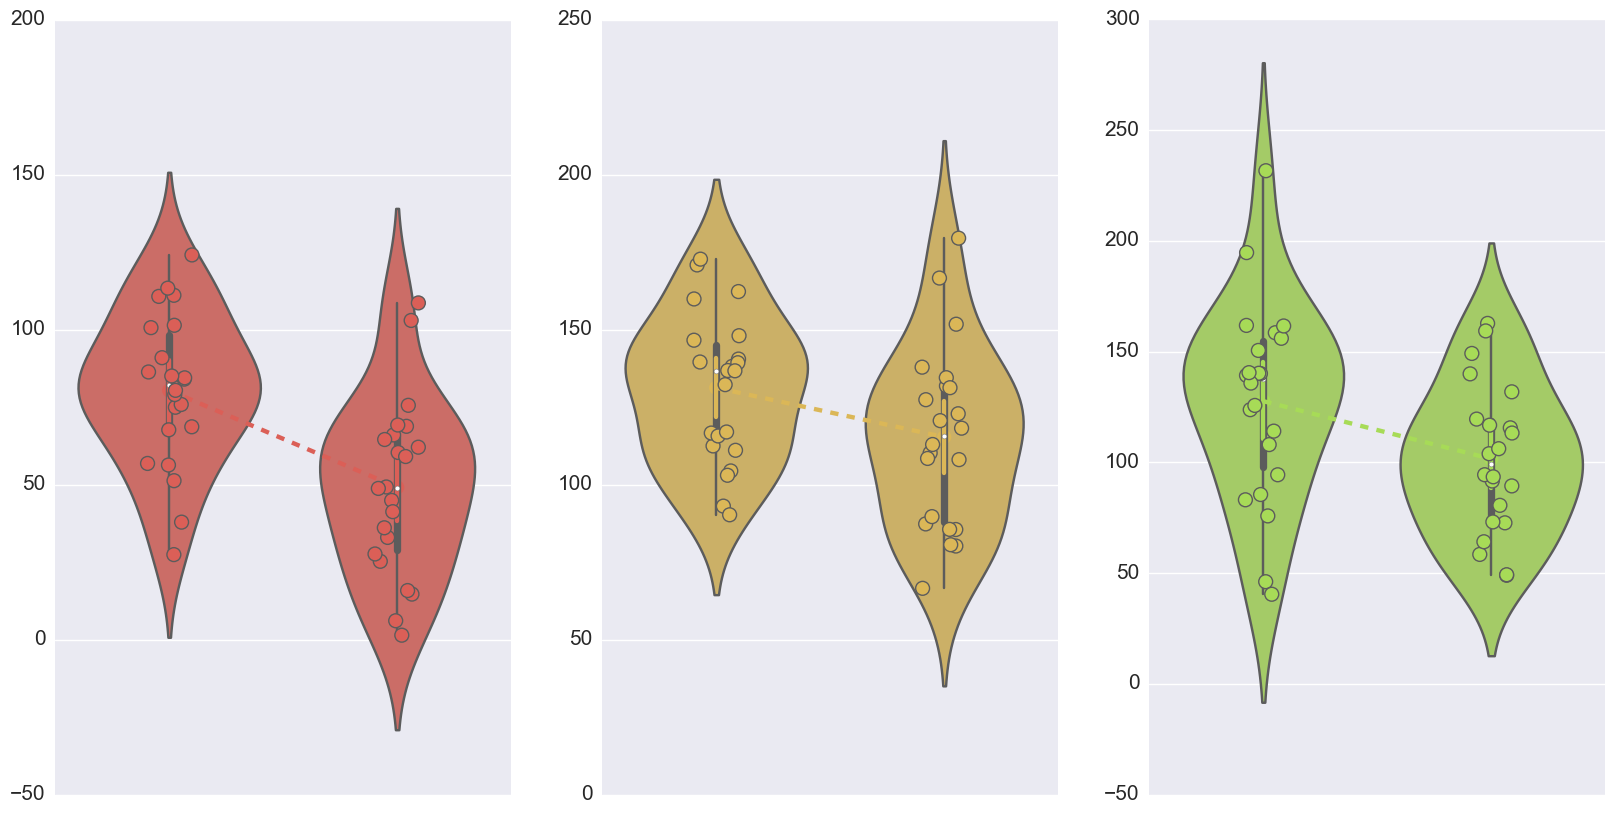

In [156]:
make_plot(controls_a,patients_a,m1 = 'STN', m2 = 'SN', m3 = 'RN')#, save = 'nucleus_stats_1.png')

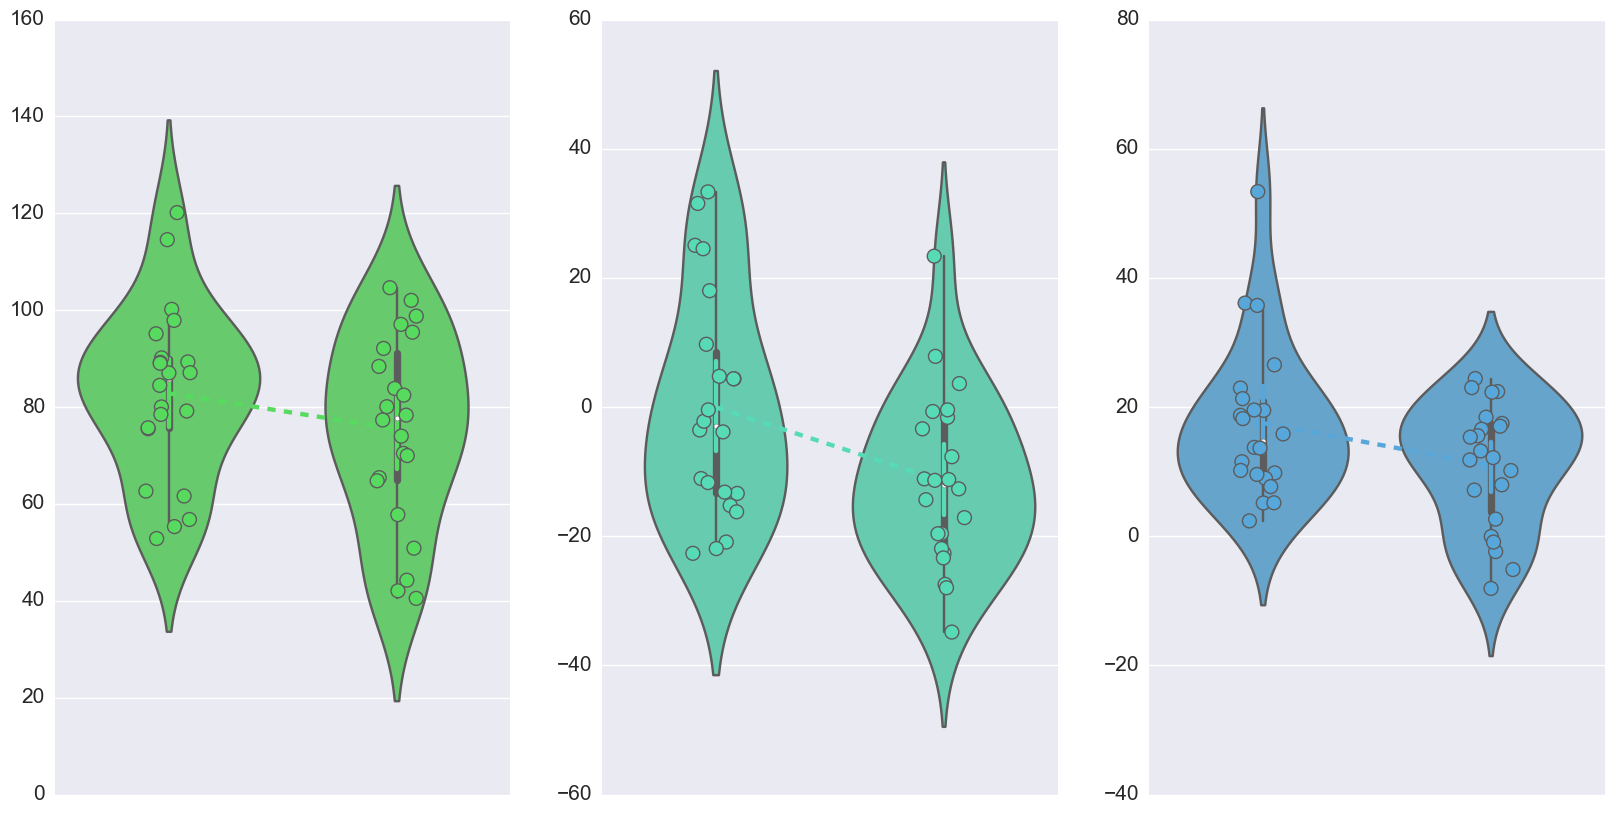

In [157]:
make_plot(controls_a,patients_a,m1 = 'Pall', m2 = 'Puta', m3 = 'Caud', pal=[3,6])#, save = 'nucleus_stats_2.png')

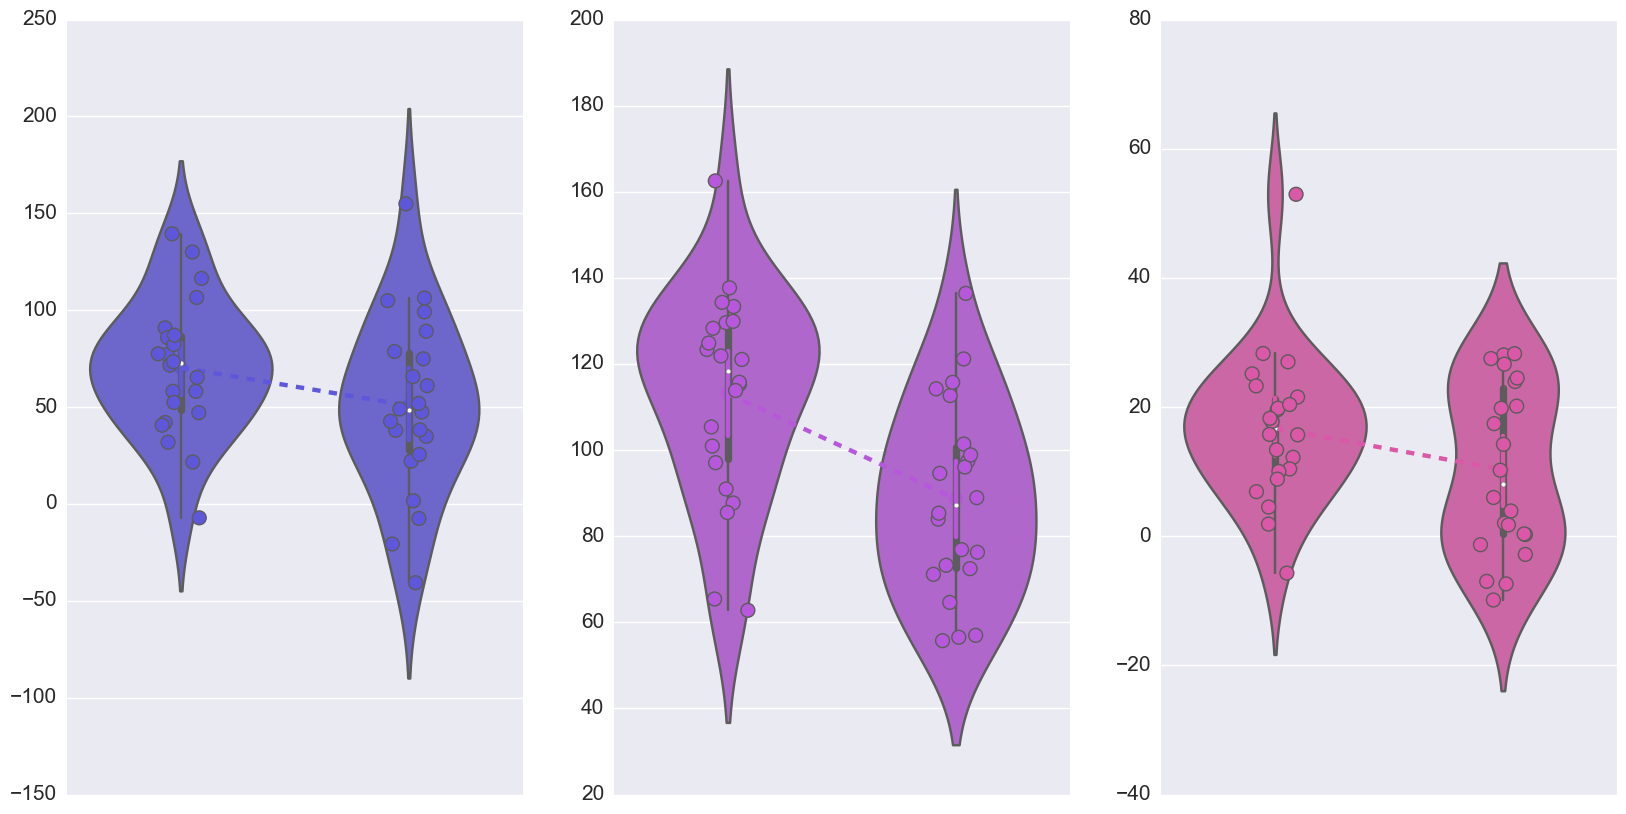

In [158]:
make_plot(controls_a,patients_a,m1 = 'DN', m2 = 'BrainStem', m3 = 'RBasalGanglia', pal=[6,9])#,save = 'nucleus_stats_3.png')

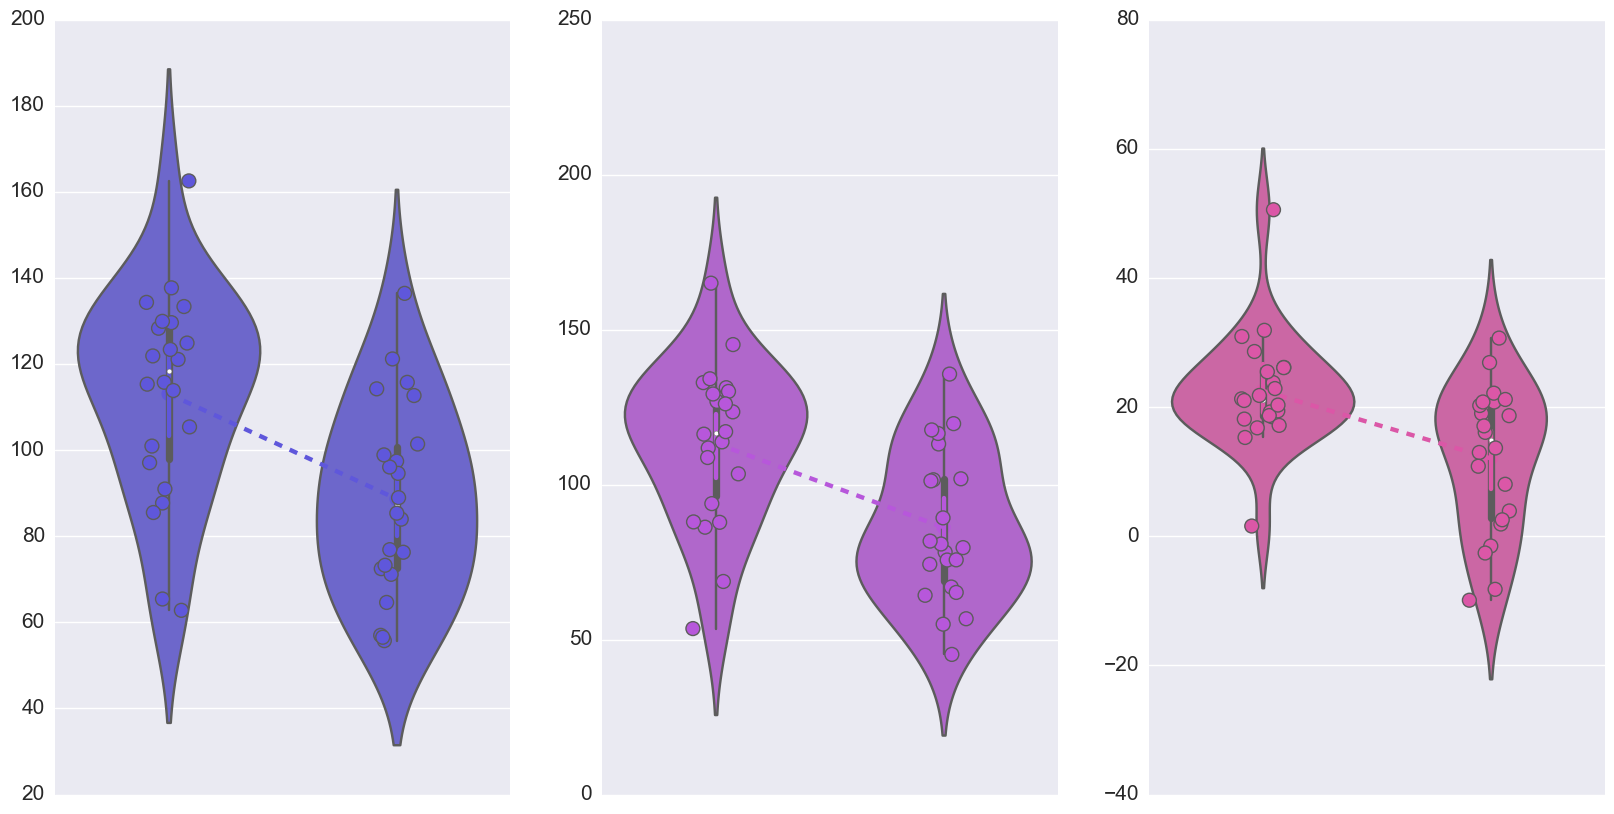

In [159]:
make_plot(controls_a,patients_a,m1 = 'BrainStem', m2 = 'LBrainStem', m3 = 'LBasalGanglia', pal=[6,9])

In [160]:
def make_plot_all(df1,df2, m, pal= [0,3], save = None):
    sns.set(font_scale=1.5)
    sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
    f, (ax1,ax2,ax3,ax4,ax5,ax6)= plt.subplots(nrows = 1, ncols = 6)
    f.set_size_inches([40,10])
    pallete = sns.color_palette("hls", 6)#[pal[0]:pal[1]]
    x = 1000
                
    def make_multiplot(m,  pallete, ax, jitter = 0.1, font=30):   
        data = [df1[m]*x, df2[m]*x] 
        g = sns.violinplot( data = data, color = pallete, ax = ax,whis= 1)#, scale='count')
        g = sns.stripplot(data=data, color = pallete, jitter= jitter, ax = ax, size = 10, linewidth=1)
        g = sns.pointplot(data=data, color = pallete, linestyles=['--'], markers=['o'], ax =ax)
        #g.legend([m], fontsize = 30 , handlelength=0, loc = 2)
        g.set(xticklabels=[])  
        def annot_datapoints(df, m, xr, alpha = 0.2, ax = ax):
            for i,s in zip(df[m]* x, df.index):
                ann = ax.annotate('%s'%s, xy= (xr,i), size= 15, color='b', alpha = alpha)
        
        #annot_datapoints(df1,m, -0.4)
        #annot_datapoints(df2,m, 0.4)
        #g.set(ylim=(-50, 300))

    make_multiplot(m[0], pallete[0], ax1)
    make_multiplot(m[1], pallete[1], ax2)
    make_multiplot(m[2], pallete[2], ax3)
    make_multiplot(m[3], pallete[3], ax4)
    make_multiplot(m[4], pallete[4], ax5)
    make_multiplot(m[5], pallete[5], ax6)
    
    fname = os.path.join(savefigdir, 'stats_all.png')
    f.savefig(fname , dpi = 300, bbox_inches='tight', transparent = False)

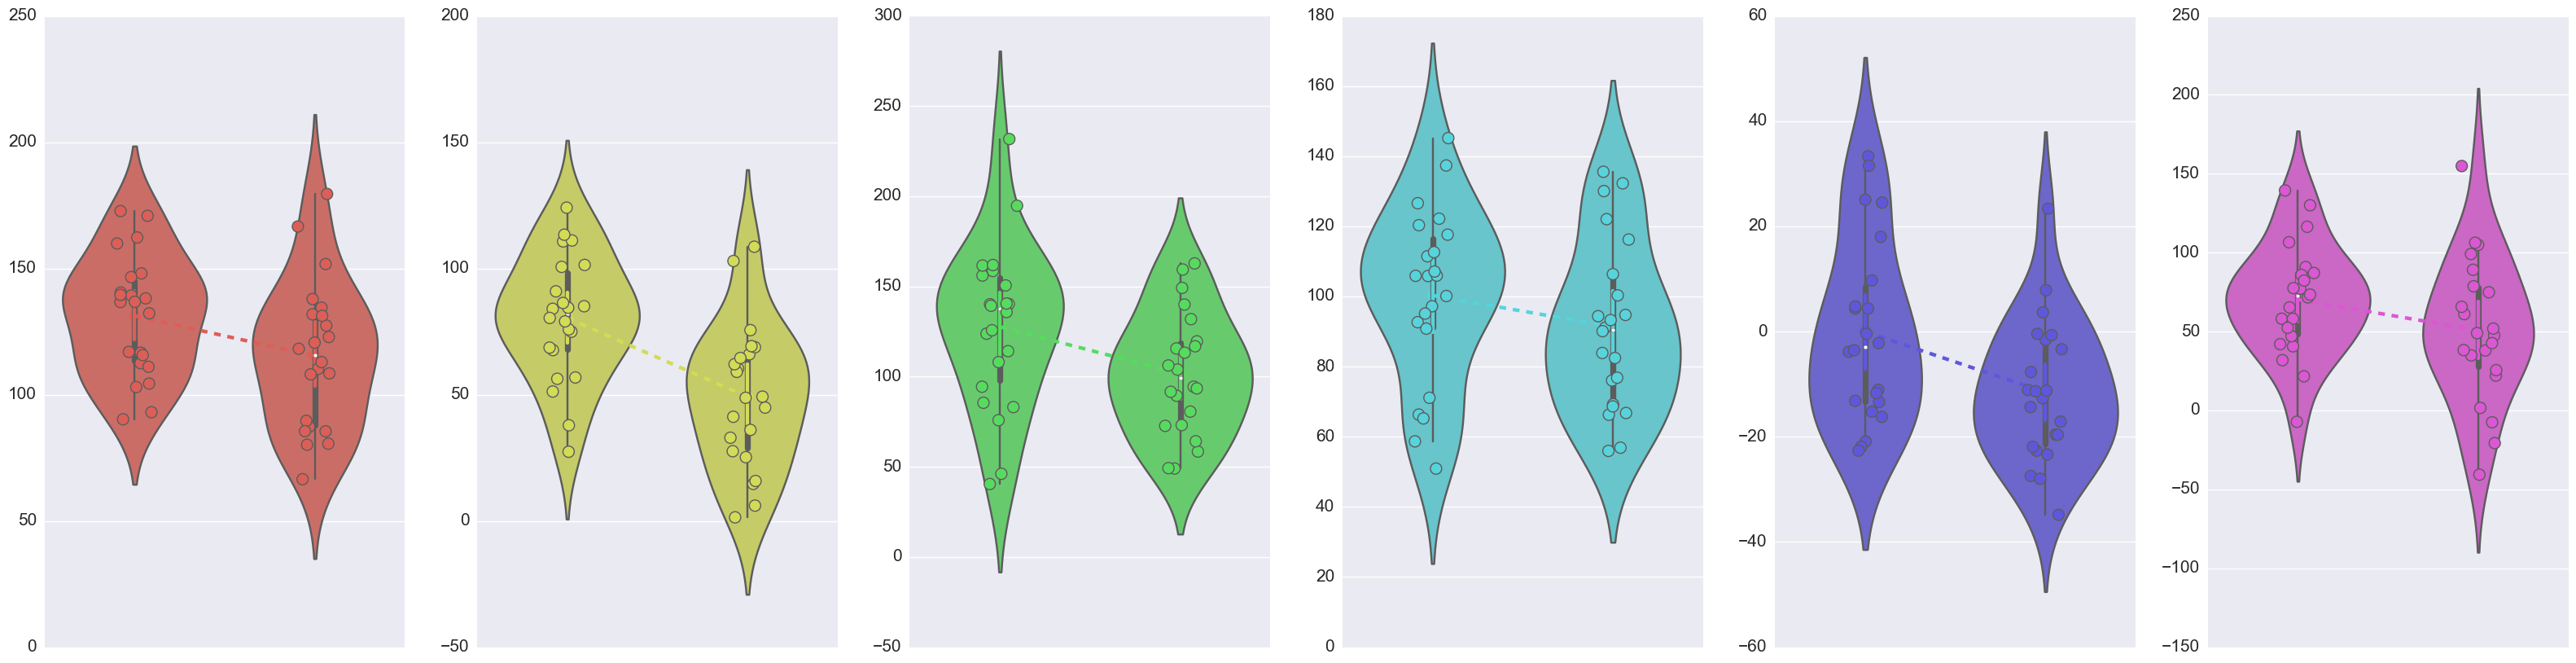

In [161]:
nuclei  = ['SN', 'STN', 'RN','GPi','Puta','DN']
make_plot_all(controls_a,patients_a,nuclei)